# Subpixel Matching - Part I

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
# Enable the GPU
autocnet.cuda(enable=True)

from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs
# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## Create the CandidateGraph
Just like the other notebooks this cell creates the candidate graph.  This also patches in functionality to the object on the fly.  To get a handle on what is going on, checkout the [Advanced 1. Extending the CandidateGraph](Advanced 1. Extending the CandidateGraph.ipynb) notebook.

In [2]:
# Create the candidate graph and enable a GPU
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Define a function to do the feature extraction.
def extract_features(self, arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    # Match the interface defined in the edge.
    self.keypoints = kp
    self.descriptors = des
    
    self['downsample_amount'] = downsample_amount

# Import the class and update it.  This updates the current instance of the CandidateGraph
from autocnet.graph.node import Node
Node.extract_features = extract_features

# Extract the features
cg.extract_features(thresh=1)

## Match and Find Outliers

In [3]:
# Match
cg.match()

# Apply outlier detection - see the above linked notebook if you are curious about what is going on here.
for s,d,e in cg.edges_iter(data=True):
    e.masks['ratio'] = e.matches.ambiguity <= e.matches.ambiguity.quantile(0.015)
    e.masks['score'] = e.matches.score >= e.matches.score.quantile(0.85)
    
# Compute the F Matrix
cg.compute_fundamental_matrices(clean_keys=['ratio', 'score'])

## Subpixel Refinement

This is a 100% experiment with the Apollo Pan data.  Is it possible to work at a silly reduced resolution and then subpixel match by scaling the correspondence to the correct place?

The first step is to visualize what is going to happen.

- Scale the keypoint to full resolution
- Extract a search template from one of the images
- Extract a search space from the other image
- Upsample each using a non-linear interpolation (parabola basically)
- Apply a standard normalized cross correlation metric to determine the maximum correlation

In line # 28, below, an argument `func=cv2.TM_CCORR_NORMED` is being passed.  This determines the metric that is used to compute the correlation between the search template and the search space.  The default is to use a normalized correlation coefficient.  This metric was not working well for the Apollo Pan data, so we pass a different computation function - the normalized cross correlation metric.

In [4]:
from autocnet.matcher.subpixel import clip_roi, subpixel_offset

4.9375 -1.375 0.9997124075889587


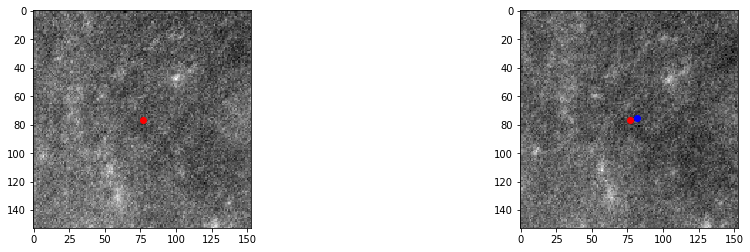

2.5 -3.1875 0.9997014999389648


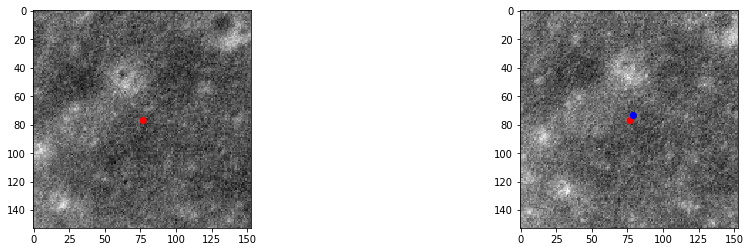

6.0 -0.0625 0.9997513890266418


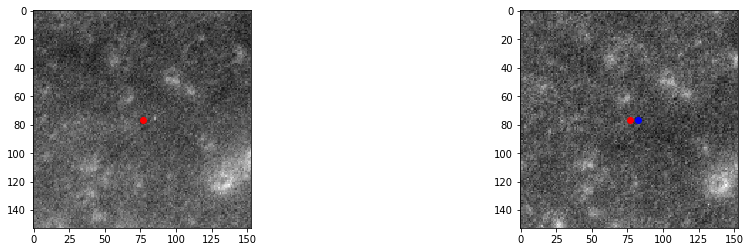

-1.75 -4.375 0.9997540712356567


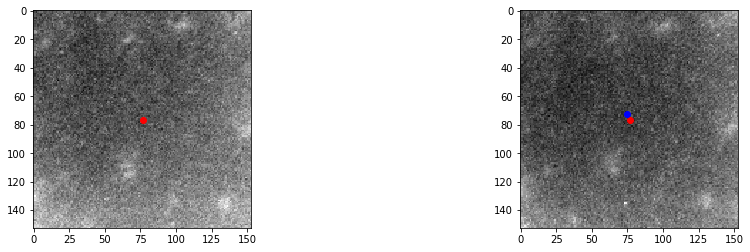

5.25 3.0625 0.9996282458305359


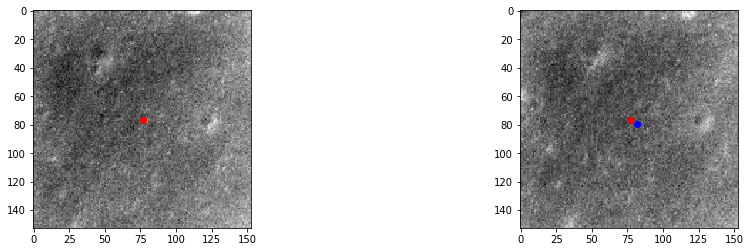

-2.75 4.3125 0.9997715353965759


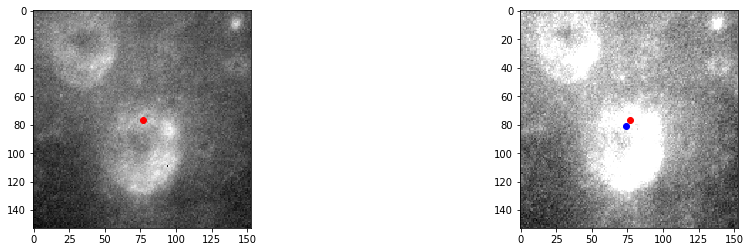

-2.5 5.8125 0.9997096061706543


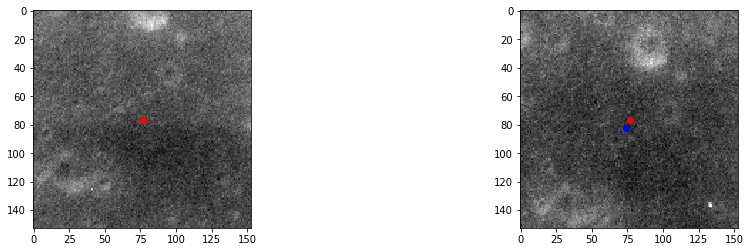

-1.8125 -2.5 0.9997724890708923


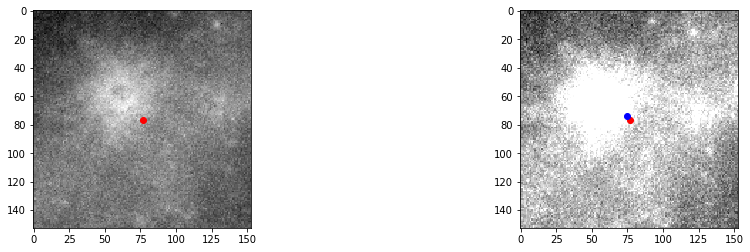

2.25 -3.0625 0.9996821880340576


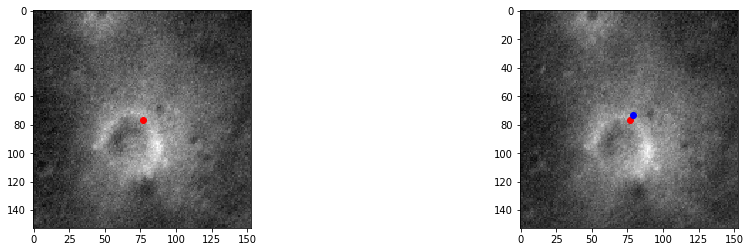

-4.3125 4.75 0.9998062252998352


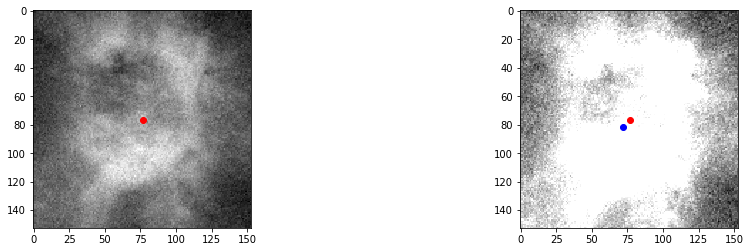

5.625 -6.0 0.9997365474700928


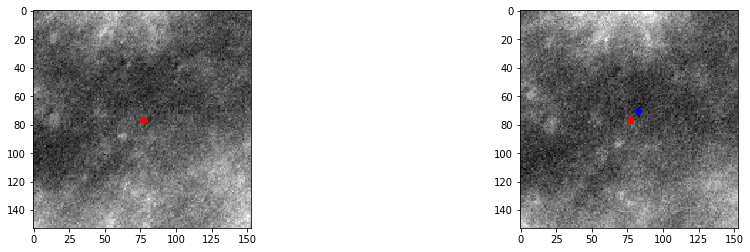

-1.25 -5.5625 0.9997563362121582


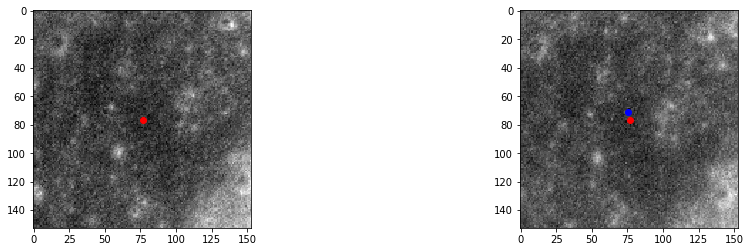

2.3125 0.5625 0.9995174407958984


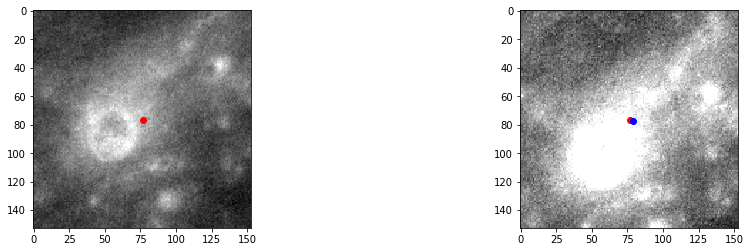

-5.0 4.875 0.9997614622116089


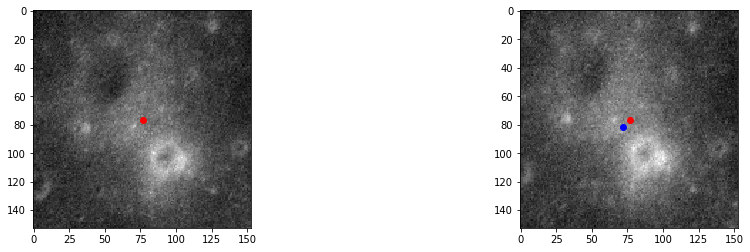

-3.875 -6.0 0.9996576905250549


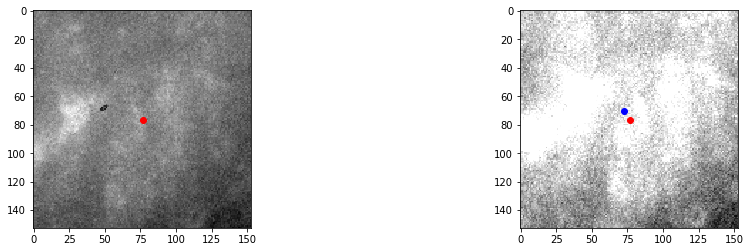

In [39]:
import cv2
# Scale the keypoints coordinates back to full resolution.
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x *= n['downsample_amount']
    n.keypoints.y *= n['downsample_amount']
    
# Apply the subpixel registration
#cg.subpixel_register(clean_keys=['fundamental'], tiled=True)
e = cg.edge[0][1]
img1 = e.source.geodata
img2 = e.destination.geodata

mask = cg.edge[0][1].masks.fundamental
matches = cg.edge[0][1].matches[mask]

size = 153

for i, r in matches.iterrows():
    sx, sy = e.source.get_keypoint_coordinates(r.source_idx)
    dx, dy = e.destination.get_keypoint_coordinates(r.destination_idx)
    fig, (ax1, ax2) = plt.subplots(1,2)
    sa = clip_roi(img1, (sx,sy), size)
    da = clip_roi(img2, (dx, dy), size)
    
    sa_temp = clip_roi(img1, (sx, sy), 17)
    da_space = clip_roi(img2, (dx, dy), 29)
    
    x_off, y_off, strength = subpixel_offset(sa_temp,da_space, func=cv2.TM_CCORR_NORMED)  
    print(x_off, y_off, strength)
    ax1.imshow(sa, cmap='gray')
    ax1.plot(size/2, size/2, 'ro')
    ax2.imshow(da, cmap='gray')
    ax2.plot(size/2, size/2, 'ro')
    ax2.plot((size/2) + x_off, (size/2) + y_off, 'bo')
    show()

# Scale the keypoint coordinates back to the reduced resolution
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x /= n['downsample_amount']
    n.keypoints.y /= n['downsample_amount']